# SageMaker Model Monitor - visualizing monitoring results


The prebuilt container from SageMaker computes a variety of statistics and evaluates constraints out of the box. This notebook demonstrates how you can visualize them. You can grab the ProcessingJob arn from the executions behind a MonitoringSchedule and use this notebook to visualize the results.

Let's import some python libraries that will be helpful for visualization

In [2]:
!pip install numpy==1.16.5

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached numpy-1.16.5-cp37-cp37m-manylinux1_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyarrow 5.0.0 requires numpy>=1.16.6, but you have numpy 1.16.5 which is incompatible.
numba 0.54.0 requires numpy<1.21,>=1.17, but you have numpy 1.16.5 which is incompatible.


In [1]:
from IPython.display import HTML, display
import json
import os
import boto3

import sagemaker
from sagemaker import session
from sagemaker.model_monitor import MonitoringExecution
from sagemaker.s3 import S3Downloader

## Get Utilities for Rendering

The functions for plotting and rendering distribution statistics or constraint violations are implemented in a `utils` file so let's grab that.

In [3]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py

import utils as mu

--2021-09-12 23:19:02--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13024 (13K) [text/plain]
Saving to: ‘utils.py.3’

utils.py.3          100%[===================>]  12.72K  --.-KB/s    in 0s      

2021-09-12 23:19:02 (89.6 MB/s) - ‘utils.py.3’ saved [13024/13024]



## Get Execution and Baseline details from Processing Job Arn

Enter the ProcessingJob arn for an execution of a MonitoringSchedule below to get the result files associated with that execution

In [6]:
processing_job_arn = "arn:aws:sagemaker:us-east-2:325011675573:processing-job/model-monitoring-202109122300-c2649fb5f062697d54a33206"

In [7]:
execution = MonitoringExecution.from_processing_arn(
    sagemaker_session=session.Session(), processing_job_arn=processing_job_arn
)
exec_inputs = {inp["InputName"]: inp for inp in execution.describe()["ProcessingInputs"]}
exec_results = execution.output.destination

In [8]:
baseline_statistics_filepath = (
    exec_inputs["baseline"]["S3Input"]["S3Uri"] if "baseline" in exec_inputs else None
)
execution_statistics_filepath = os.path.join(exec_results, "statistics.json")
violations_filepath = os.path.join(exec_results, "constraint_violations.json")

baseline_statistics = (
    json.loads(S3Downloader.read_file(baseline_statistics_filepath))
    if baseline_statistics_filepath is not None
    else None
)
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))["violations"]

In [14]:
execution_statistics_filepath

's3://sagemaker-us-east-2-325011675573/sagemaker/DEMO-ModelMonitor/reports/DEMO-xgb-churn-pred-model-monitor-2021-09-12-21-35-18/DEMO-xgb-churn-pred-model-monitor-schedule-2021-09-12-22-57-21/2021/09/12/23/statistics.json'

## Overview

The code below shows the violations and constraint checks across all features in a simple table.

In [9]:
mu.show_violation_df(
    baseline_statistics=baseline_statistics,
    latest_statistics=execution_statistics,
    violations=violations,
)

,data_type,completeness,baseline_drift,categorical_values
Account Length,Integral,100.00%,N/A,N/A
Area Code_408,Fractional,100.00%,N/A,N/A
Area Code_415,Fractional,100.00%,N/A,N/A
Area Code_510,Fractional,100.00%,N/A,N/A
Churn,Fractional,100.00%,N/A,N/A
CustServ Calls,Integral,100.00%,N/A,N/A
Day Calls,Integral,100.00%,N/A,N/A
Day Mins,Fractional,100.00%,N/A,N/A
Eve Calls,Integral,100.00%,N/A,N/A
Eve Mins,Fractional,100.00%,N/A,N/A


## Distributions

This section visualizes the distribution and renders the distribution statistics for all features

In [10]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,180,0,0.124452,22.40145,0.243704,0.006144,0.989564
Account Length,180,0,99.883333,17979.00000,40.165944,10.000000,232.000000
VMail Message,180,0,7.028333,1265.10000,12.663040,0.000000,43.000000
Day Mins,180,0,178.213333,32078.40000,54.674916,46.500000,328.100000
Day Calls,180,0,101.100000,18198.00000,19.448822,36.000000,150.000000
...,...,...,...,...,...,...,...
Area Code_510,180,0,0.273333,49.20000,0.447164,0.000000,1.200000
Int'l Plan_no,180,0,0.929444,167.30000,0.260277,0.000000,1.300000
Int'l Plan_yes,180,0,0.075222,13.54000,0.261120,0.000000,1.000000
VMail Plan_no,180,0,0.746667,134.40000,0.438482,0.000000,1.400000


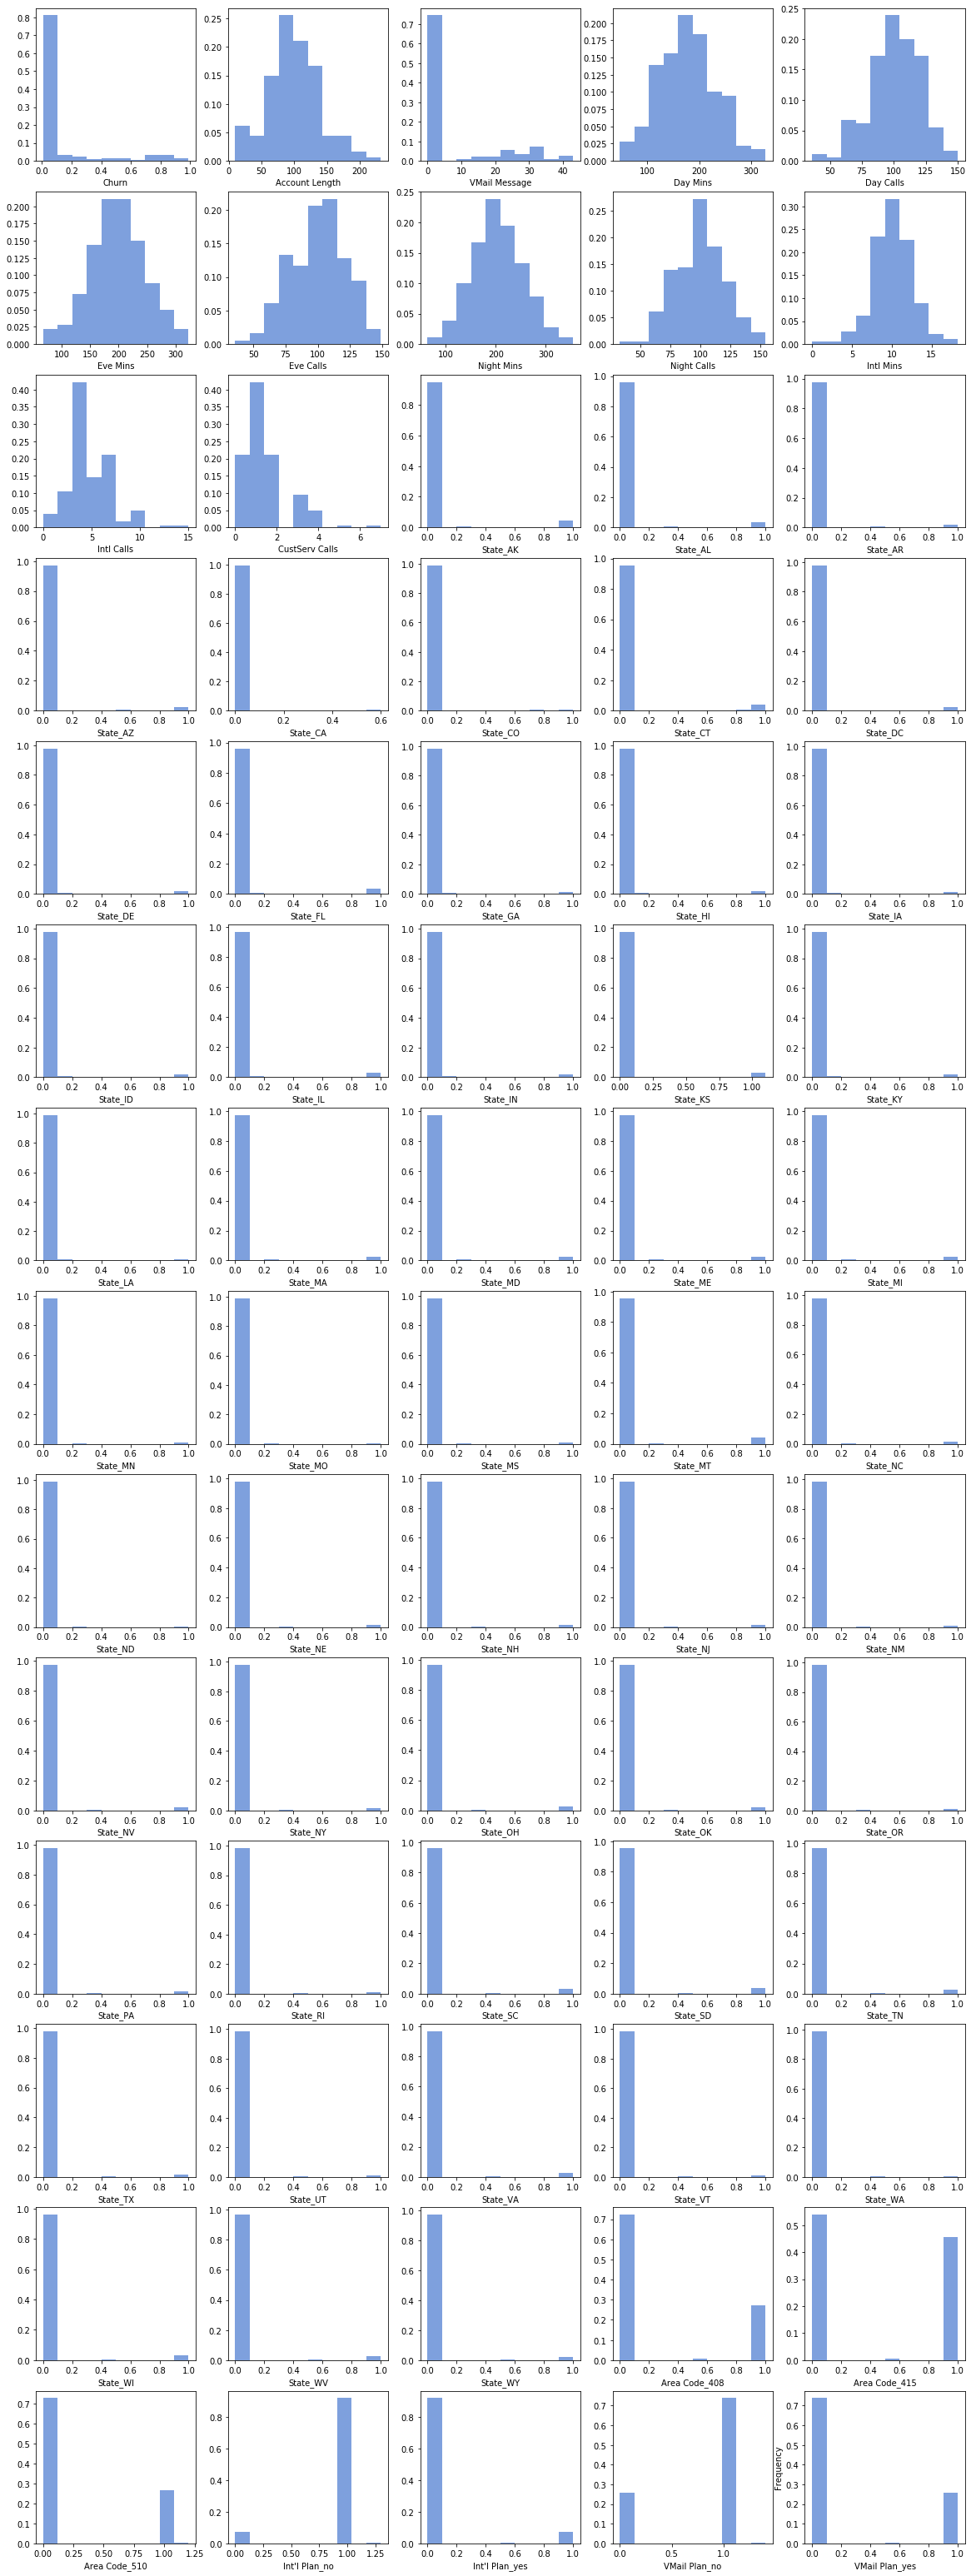

In [11]:
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,180,0,0.124452,22.40145,0.243704,0.006144,0.989564
Account Length,180,0,99.883333,17979.00000,40.165944,10.000000,232.000000
VMail Message,180,0,7.028333,1265.10000,12.663040,0.000000,43.000000
Day Mins,180,0,178.213333,32078.40000,54.674916,46.500000,328.100000
Day Calls,180,0,101.100000,18198.00000,19.448822,36.000000,150.000000
...,...,...,...,...,...,...,...
Area Code_510,180,0,0.273333,49.20000,0.447164,0.000000,1.200000
Int'l Plan_no,180,0,0.929444,167.30000,0.260277,0.000000,1.300000
Int'l Plan_yes,180,0,0.075222,13.54000,0.261120,0.000000,1.000000
VMail Plan_no,180,0,0.746667,134.40000,0.438482,0.000000,1.400000


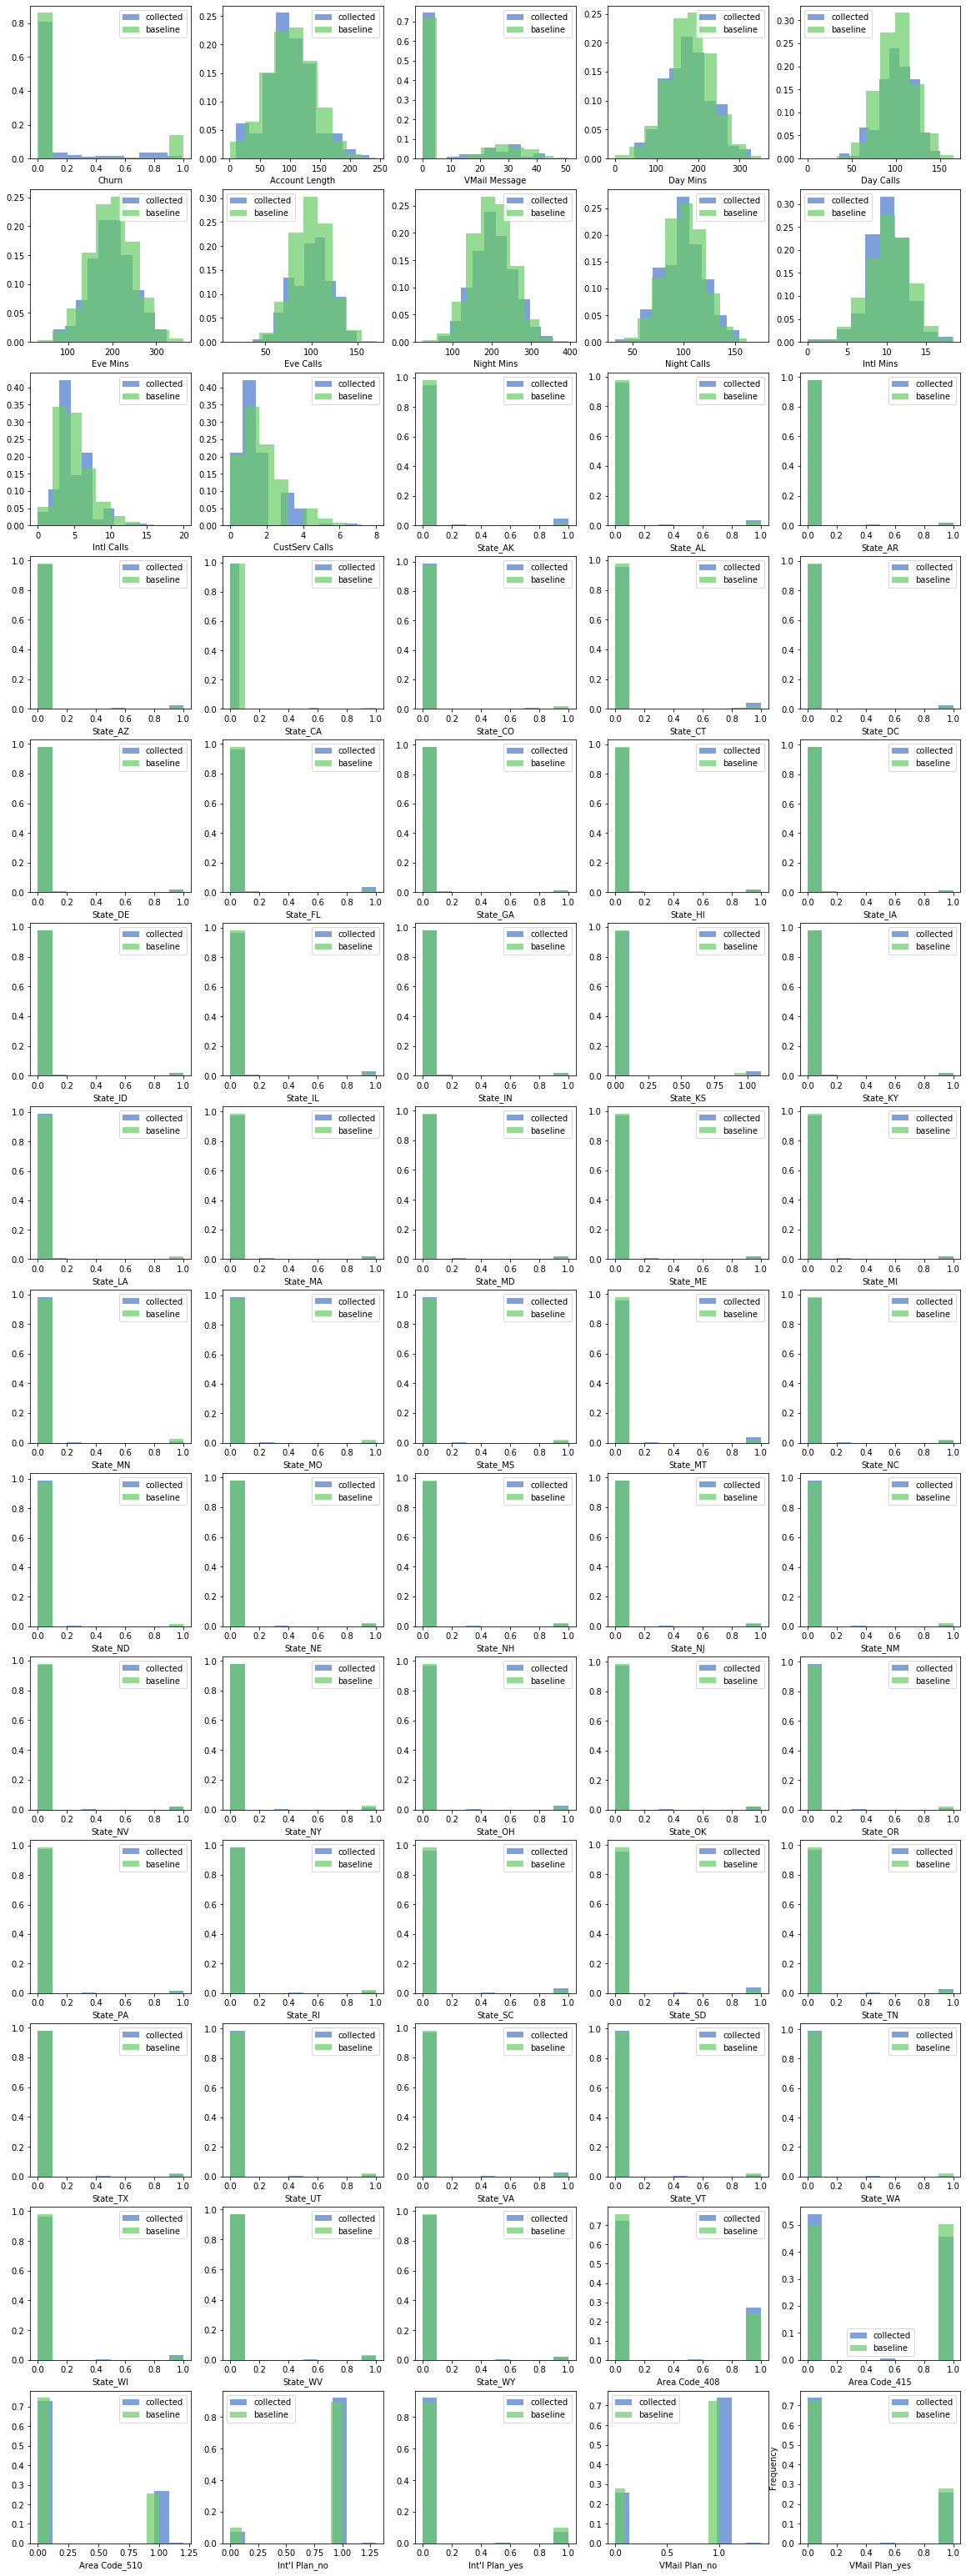

In [12]:
mu.show_distributions(features, feature_baselines)